# Description
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# File Descriptions
1. sales_train.csv - the training set. Daily historical data from January 2013 to October 2015;

2. test.csv - the test set. You need to forecast the sales for these shops and products for November 2015;

3. sample_submission.csv - a sample submission file in the correct format;

4. items.csv - supplemental information about the items/products;

5. item_categories.csv - supplemental information about the items categories;

6. shops.csv - supplemental information about the shops.

# Variables
* ID - an Id that represents a (Shop, Item) tuple within the test set;

* shop_id - unique identifier of a shop;

* item_id - unique identifier of a product;

* item_category_id - unique identifier of item category;

* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure;

* item_price - current price of an item;

* date - date in format dd/mm/yyyy;

* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33;

* item_name - name of item;

* shop_name - name of shop;

* item_category_name - name of item category.



This dataset is permitted to be used for any purpose, including commercial use.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('whitegrid')

In [2]:
# Our first goal is to read the four datasets: SALES_TRAIN,
# ITEMS, ITEM_CATEGORIES and SHOPS, and then, merge them!
sales_train      =  pd.read_csv('sales_train.csv')
items            =  pd.read_csv('items.csv')
item_categories  =  pd.read_csv('item_categories.csv')
shops            =  pd.read_csv('shops.csv')

In [3]:
# Merging ITEMS and ITEM_CATEGORY datasets
item_categories_dict = dict(zip(
    item_categories['item_category_id']
    , item_categories['item_category_name']
))

item_categories_items_list = [
    item_categories_dict[x]
    for x in items['item_category_id']
]

items.insert(2, 'item_category_name', item_categories_items_list)

In [4]:
# Merging SALES TRAIN and SHOPS datasets
shops_dict = dict(zip(
    shops['shop_id']
    , shops['shop_name']
))

shops_sales_train_list = [
    shops_dict[x]
    for x in sales_train['shop_id']
]

sales_train.insert(3, 'shop_name', shops_sales_train_list)

In [5]:
# Merging SALES TRAIN-SHOPS and ITEMS-ITEM_CATEGORIES
# datasets (ITEM NAME)
items_dict = dict(zip(
    items['item_id']
    , items['item_name']
))

items_sales_train_list = [
    items_dict[x]
    for x in sales_train['item_id']
]

sales_train.insert(5, 'item_name', items_sales_train_list)

In [6]:
# Merging SALES TRAIN-SHOPS and ITEMS-ITEM_CATEGORIES
# datasets (ITEM CATEGORY)
items_category_id_dict = dict(zip(
    items['item_id']
    , items['item_category_id']
))

items_category_id_sales_train_list = [
    items_category_id_dict[x]
    for x in sales_train['item_id']
]

sales_train.insert(7, 'item_category_id', items_category_id_sales_train_list)

In [7]:
# Merging SALES TRAIN-SHOPS and ITEMS-ITEM_CATEGORIES
# datasets (ITEM CATEGORY NAME)
items_category_name_dict = dict(zip(
    items['item_category_id']
    , items['item_category_name']
))

items_category_name_sales_train_list = [
    items_category_name_dict[x]
    for x in sales_train['item_category_id']
]

sales_train.insert(8, 'item_category_name', items_category_name_sales_train_list)

In [8]:
# Before getting our final version of the Train Dataset
# let's take a peep in the Test dataset
test = pd.read_csv('test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


There are just the shop_id and item_id features on it. So, let's drop all columns, but these two, date_block_num and the target (item_cnt_day) in order to create our baseline model.

In [9]:
##########################
# Dataset - Final Result #
##########################

full_train_df = sales_train.copy()

# Dropping all columns except shop_id, item_id, date_block_num and 
# item_cnt_day
features_to_drop = ['date'
                    , 'shop_name'
                    , 'item_name'
                    , 'item_price'
                    , 'item_category_id'
                    , 'item_category_name']

train_df = full_train_df.drop(features_to_drop, axis=1).copy()
train_df

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0
...,...,...,...,...
2935844,33,25,7409,1.0
2935845,33,25,7460,1.0
2935846,33,25,7459,1.0
2935847,33,25,7440,1.0


In [10]:
# First, let's check out the data type of each feature
train_df.dtypes

date_block_num      int64
shop_id             int64
item_id             int64
item_cnt_day      float64
dtype: object

In [11]:
# The first issue to fix: as far as "item_cnt_day"
# is the amount of products sold in one day, it's not
# possible to sell 5 and a half products. Then, we
# gotta convert this feature to "int64"
train_df['item_cnt_day'] = train_df['item_cnt_day'].astype(np.int64)
train_df.dtypes

date_block_num    int64
shop_id           int64
item_id           int64
item_cnt_day      int64
dtype: object

### Statistical Overview

In [12]:
# Now, let's see a Statistical Overview using "describe"
# method
train_df.describe()

,date_block_num,shop_id,item_id,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,2.169000e+03


Realize that item_cnt_day has negative values (the minimum value is -22). It's impossible to sold less than 0 products per day.

Let's assume that it was an typo. For instance, instead of tipping 22, the manager has tip -22. So, we just have to multiple the negative values by -1.

In [13]:
multiply_by_minus_one = lambda x: x * -1 \
                        if x < 0         \
                        else x

train_df['item_cnt_day'] = train_df['item_cnt_day'].apply(multiply_by_minus_one)

train_df.describe()

,date_block_num,shop_id,item_id,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,1.247778e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,2.616391e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,2.169000e+03


### Correlations

In [14]:
# Now, let's see the correlation between the features
train_df.corr()

,date_block_num,shop_id,item_id,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.009419
shop_id,0.019273,1.000000,0.029396,-0.005329
item_id,0.009356,0.029396,1.000000,0.016290
item_cnt_day,0.009419,-0.005329,0.016290,1.000000


Looking at the correlation table, the highest one is item_id-shop_id correlation, being 2.93%.

The others are barely higher than 1%, which means the features don't have a Liner Relationship (hasta la vista, Linear Regression Algorithm).

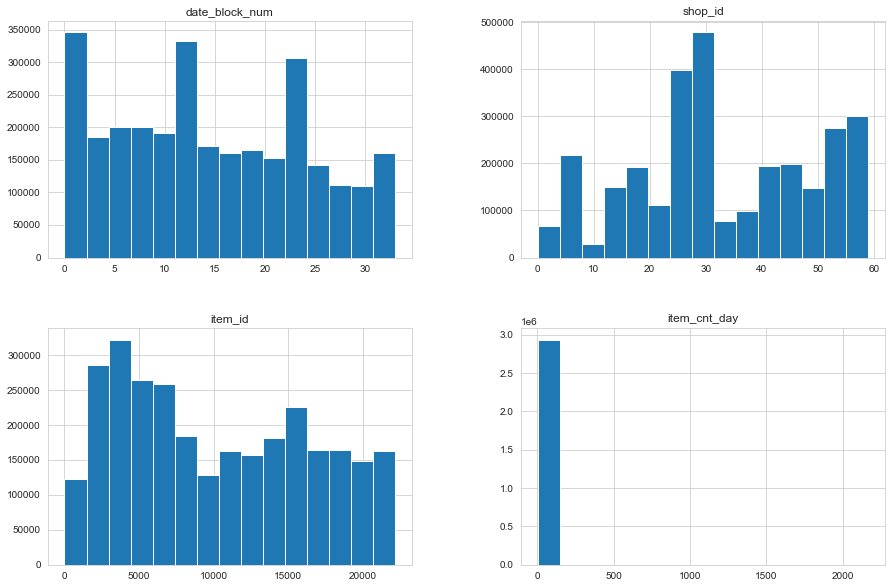

In [15]:
# As far as the features don't have a Linear Relationship
# at the moment, we won't create regression plots,
# but yes, histogram and scatter ones to see how the
# datas are spread
train_df.hist(bins=15, figsize=(15, 10));

None of the features is seems to have a Normal Distribution, then, we will probably have to apply some data transformations.

Also, we can realize that the values between the features have a huge gap between each of them, for example, the maximum value for shop_id is 60, whereas for item_id is over 20,000.

So, to avoid the model to "learn" that item_id is more important than shop_id just because that one's higher values than this one, we must apply Standardization or Normalization.

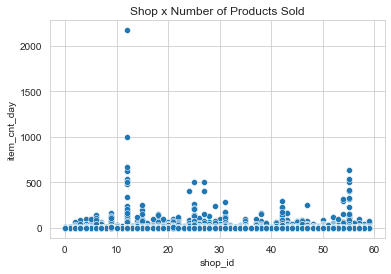

In [16]:
plt.title('Shop x Number of Products Sold')
sns.scatterplot(data=train_df
                , x=train_df['shop_id']
                , y=train_df['item_cnt_day'])
plt.show()

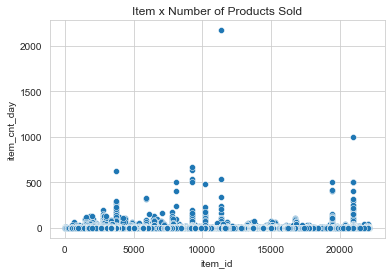

In [17]:
plt.title('Item x Number of Products Sold')
sns.scatterplot(data=train_df
                , x=train_df['item_id']
                , y=train_df['item_cnt_day'])
plt.show()

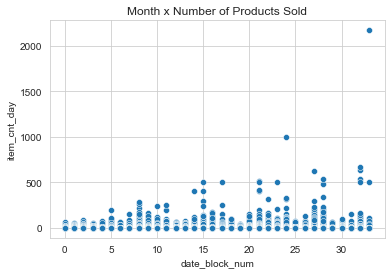

In [18]:
plt.title('Month x Number of Products Sold')
sns.scatterplot(data=train_df
                , x=train_df['date_block_num']
                , y=train_df['item_cnt_day'])
plt.show()

## Splitting Dataset into Features and Target
Since we have to predict the product's amount sold in a month per shop, we have to filter just the November Sales and group the item_cnt_day column by the others before splitting up the dataset.

In [19]:
train_df.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1
1,0,25,2552,1
2,0,25,2552,1
3,0,25,2554,1
4,0,25,2555,1


In [20]:
# Filtering Rows by November 2013 and November 2014
train_df = train_df.loc[
    (train_df['date_block_num'] == 10)
    | (train_df['date_block_num'] == 22)
]

In [21]:
# Grouping dataset
grouped_train_df = train_df.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False) \
                           .sum('item_cnt_day').copy()
grouped_train_df.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,10,2,33,2
1,10,2,97,1
2,10,2,482,2
3,10,2,791,1
4,10,2,944,1


Now, let's split it up into Target and Features!

In [22]:
X = grouped_train_df.copy()
y = X.pop('item_cnt_day')

## Feature Engineering
Before starting creating a ML Model, let's make some Data Engineering and Analysis.

Kicking off from Engineering, we will:

* check out which features are most important with Mutual Information (MI);

* try to find out similar datas in groups using K-Means Clusters;

* and check out the necessity to apply or not Principal Component Analysis (PCA).


### Mutual Information (MI)

In [23]:
from sklearn.feature_selection import mutual_info_regression

In [24]:
# Identifying Discrete (integers) and
# Continuous (float) features
discrete_features = X.dtypes == int
continuous_features = X.dtypes == float

As far as MI takes a long time to process when we have too much rows, let's calculating using the first 500,000 rows!

With this amount of rows, it'll take about 60 seconds to process.

In [25]:
# Calculating the scores in Descending Order
# using the first 500,000 rows
mi_scores_discrete_features = mutual_info_regression(X[0:500000], y[0:500000], discrete_features=discrete_features, random_state=0)
mi_scores_discrete_features = pd.Series(mi_scores_discrete_features, name='MI Scores', index=X.columns)
mi_scores_discrete_features = mi_scores_discrete_features.sort_values(ascending=False)

In [26]:
# Plotting MI Scores
def plot_mi_scores(scores):
    """
    Plots Mutual Information Scores in Ascending Order
    """
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

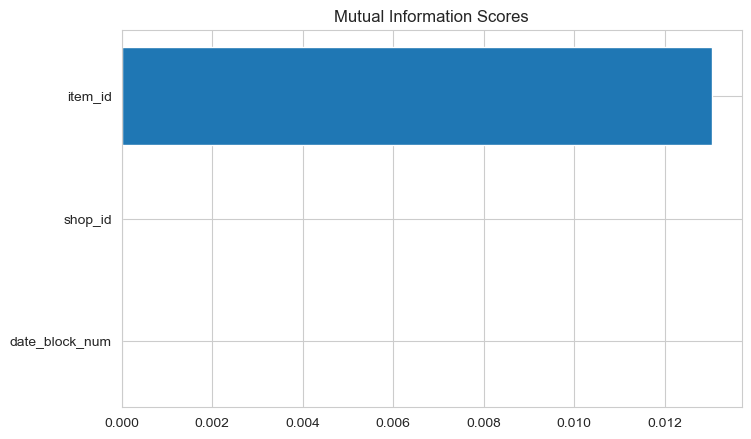

In [27]:
# Plotting Discrete Features' MI Scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores_discrete_features)

By the chart, we can realize these things:

* item_id has a high relationship in the amount sold per month;

* shop_id has a tiny relationship in the amount.

But stick it in your mind: when we apply Pipelines and Data Transformations, we can find out relationships that we can't recognize with the raw data. So, never discard an important feature before analysing it deeper!


### K-Means Cluster

In [28]:
from sklearn.cluster import KMeans

In [29]:
# First, let's find out how much clusters are great
# to find in the dataset using the WCSS and the Elbow methods
wcss = []

for i in range(1,7):
    kmeans = KMeans(n_clusters=i
                   , init='k-means++'
                   , max_iter=300
                   , n_init=10
                   , random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

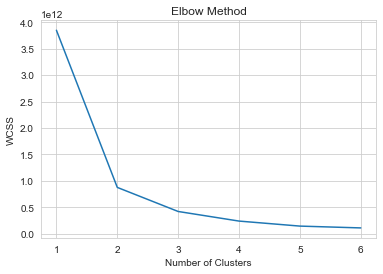

In [30]:
# Plotting the results
plt.plot(range(1,7), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

We have two elbows here: with 2 and 3 clusters. Let's choose 3 clusters!

In [31]:
# Calculating the Clusters with 3 clusters
kmeans = KMeans(n_clusters=3
               , init='k-means++'
               , max_iter=300
               , n_init=10
               , random_state=0)

X_temp = X.copy()
X_temp['cluster'] = kmeans.fit_predict(X_temp)
X_temp

,date_block_num,shop_id,item_id,cluster
0,10,2,33,1
1,10,2,97,1
2,10,2,482,1
3,10,2,791,1
4,10,2,944,1
...,...,...,...,...
97210,22,59,22050,2
97211,22,59,22087,2
97212,22,59,22088,2
97213,22,59,22091,2


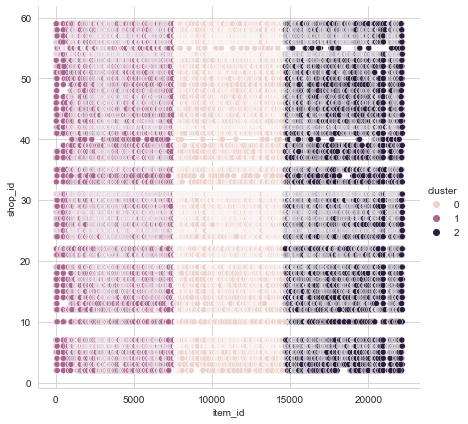

In [32]:
sns.relplot(
    x="item_id", y="shop_id", hue="cluster", data=X_temp, height=6,
);

Looking at the scatter plot above, we can realize that the clusters follow a pattern by item_id only, being:

- Cluster 0: id between 0 - 7500;
- Cluster 1: id between 7500 - 14500;
- Cluster 2: id between 14500 - 2300;

In [34]:
del X_temp

### Principal Component Analysis (PCA)

This one will be briefly! Our dataset doesn't have so much features, it has very, very few ones (just four).

So, in the first moment, we can let PCA aside and start working with Pipelines!

## Pipelines and Data Transformations
First things first, let's check out whether we have missing values.

In [35]:
# Checking out for missing values into the Features
X.isnull().sum()

date_block_num    0
shop_id           0
item_id           0
dtype: int64

In [36]:
# Checking out for missing values into the Target
y.isnull().sum()

0

There any a single missing value, which means, we don't have the need to make Imputers!!!!

Let's split up the Features into train and validation datasets.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0
                                                    , train_size=0.80
                                                    , test_size=0.20)

Now, it's Pipeline Time!

We will use MinMaxScaler to standard the datas in order to don't make the outliers have much influence in the model learning!

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [39]:
# Creating Numerical Transformer
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

In [40]:
# Bundling Preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, X.columns),
    ]
)

## Baseline ML Models
Let's create three baseline models:

* Random Forest Regressor;

* XGBoost.

In [41]:
from sklearn.metrics import mean_squared_error # add 'sqrt' to calculate RMSE

### Random Forest Regressor (RFG)

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
# Creating Model
rfg_model = RandomForestRegressor(
    n_estimators=250,
    criterion='squared_error',
    random_state=0,
)

rfg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rfg_model),
])

In [44]:
# Training and Predicting
rfg_pipeline.fit(X_train, y_train)
print('Training: Done!')
rfg_predictions = rfg_pipeline.predict(X_valid)
print('Predictions: Done!')

Training: Done!
Predictions: Done!


In [45]:
# Calculating RMSE
from math import sqrt
rfg_rmse = np.sqrt(mean_squared_error(rfg_predictions, y_valid))
print('RFG RMSE:', rfg_rmse)

RFG RMSE: 7.377907195150957


### XGBoost

In [46]:
from xgboost import XGBRegressor

In [47]:
# Creating the Model
xgb_model = XGBRegressor(
    n_estimators=500
    , learning_rate=0.05
    , n_jobs=4
)

In [48]:
# Traning the Model and Making Predictions

xgb_model.fit(
    X_train, y_train
    , early_stopping_rounds=5
    , eval_set=[(X_valid, y_valid)]
    , verbose=False
)
print('Training: Done!')

xgb_predictions = xgb_model.predict(X_valid)
print('Predictions: Done!')

C:\Users\vlado\anaconda3\envs\SF\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training: Done!
Predictions: Done!


In [49]:
# Evaluating
xgb_rmse = sqrt(mean_squared_error(xgb_predictions, y_valid))
print('RMSE:', xgb_rmse)

RMSE: 6.33938609990329


## Machine Learning Explainability
In this step, we will use:

* Permutation Importance to find out each which features have the bigger impact on the predictions;


### Permutation Importance

In [50]:
import eli5
from eli5.sklearn import PermutationImportance

In [51]:
# Calculating Permutation Importance
perm = PermutationImportance(
    rfg_model, random_state=0
).fit(X_valid.values, y_valid.values)

In [52]:
# Plotting the Results
eli5.show_weights(perm, feature_names=X_valid.columns.tolist())

C:\Users\vlado\anaconda3\envs\SF\lib\site-packages\eli5\formatters\html.py:233: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,item_id
0 ± 0.0000,shop_id
0 ± 0.0000,date_block_num


It's kind of imporessive. In a nutshell, the features' order doesn't matter. It can happen due to tow reasons:

1. The gap between the values are not too big (all the ids are incremented by 1);

2. These features doesn't have any influences to the target and there are other external features to consider;

As far as these features were provided by the competition host, let's assume that the first assumption is the right one!

## Making Predictions
Now, after all of this job, we will make predictioons using the Test dataset!!

In [53]:
# Calculating Clusters in the Test Dataset using K-Means
test.pop('ID')
test

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [54]:
# Adding November 2015 (34th month)
test['date_block_num'] = 34
test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [83]:
# RGF
# Making Predictions and Saving Them into a File
predictions_test = rfg_pipeline.predict(test)
output = pd.DataFrame({
    'ID': test.index
    ,  'item_cnt_month': predictions_test
})

output.to_csv('submission.csv', index=False)